This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray IRIS backend

In this example, we read IRIS (sigmet) data files using the xradar `iris` xarray backend.

In [1]:
import glob
import gzip
import io
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import xradar as xd
import datatree as xt
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

## Load IRIS Volume Data

In [2]:
fpath = "sigmet/SUR210819000227.RAWKPJV"
f = wrl.util.get_wradlib_data_file(fpath)
vol = xd.io.open_iris_datatree(f, reindex_angle=False)

## Inspect RadarVolume

In [3]:
display(vol)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       latitude             float64 8B 58.48
│       longitude            float64 8B 25.52
│       altitude             float64 8B 157.0
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2021-08-19T00:02:28Z'
│       time_coverage_end    <U20 80B '2021-08-19T00:02:49Z'
│   Attributes:
│       Conventions:      None
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── DataTree('radar_parameters')
│       Dimensions:    ()
│       Coordinates:
│           longitude  float64 8B ...
│           latitude   float64 8B ...
│           altitude   float64 8B ...
│       Data variables:
│           *empty*
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 359, range: 833)
        Coordinates:
            elevation          (azimuth) float32 1kB ...
            time               (azimuth) datetime64[ns] 3kB 2021-08-19T00:02:31.10400...
          * range              (range) float32 3kB 150.0 450.0 ... 2.494e+05 2.498e+05
            longitude          float64 8B ...
            latitude           float64 8B ...
            altitude           float64 8B ...
          * azimuth            (azimuth) float32 1kB 0.03021 1.035 2.054 ... 358.0 359.0
        Data variables: (12/16)
            DBTH               (azimuth, range) float32 1MB ...
            DBZH               (azimuth, range) float32 1MB ...
            VRADH              (azimuth, range) float32 1MB ...
            WRADH              (azimuth, range) float32 1MB ...
            ZDR                (azimuth, range) float32 1MB ...
            KDP                (azimuth, range) float32 1MB ...
            ...                 ...
            SNRH               (azimuth, range) float32 1MB ...
            sweep_mode         <U20 80B ...
            sweep_number       int64 8B ...
            prt_mode           <U7 28B ...
            follow_mode        <U7 28B ...
            sweep_fixed_angle  float64 8B ...

## Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       latitude             float64 8B 58.48
│       longitude            float64 8B 25.52
│       altitude             float64 8B 157.0
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2021-08-19T00:02:28Z'
│       time_coverage_end    <U20 80B '2021-08-19T00:02:49Z'
│   Attributes:
│       Conventions:      None
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── DataTree('radar_parameters')
│       Dimensions:    ()
│       Coordinates:
│           longitude  float64 8B ...
│           latitude   float64 8B ...
│           altitude   float64 8B ...
│       Data variables:
│           *empty*
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 359, range: 833)
        Coordinates:
            elevation          (azimuth) float32 1kB ...
            time               (azimuth) datetime64[ns] 3kB 2021-08-19T00:02:31.10400...
          * range              (range) float32 3kB 150.0 450.0 ... 2.494e+05 2.498e+05
            longitude          float64 8B ...
            latitude           float64 8B ...
            altitude           float64 8B ...
          * azimuth            (azimuth) float32 1kB 0.03021 1.035 2.054 ... 358.0 359.0
        Data variables: (12/16)
            DBTH               (azimuth, range) float32 1MB ...
            DBZH               (azimuth, range) float32 1MB ...
            VRADH              (azimuth, range) float32 1MB ...
            WRADH              (azimuth, range) float32 1MB ...
            ZDR                (azimuth, range) float32 1MB ...
            KDP                (azimuth, range) float32 1MB ...
            ...                 ...
            SNRH               (azimuth, range) float32 1MB ...
            sweep_mode         <U20 80B ...
            sweep_number       int64 8B ...
            prt_mode           <U7 28B ...
            follow_mode        <U7 28B ...
            sweep_fixed_angle  float64 8B ...

## Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol["sweep_0"])

DataTree('sweep_0', parent="root")
    Dimensions:            (azimuth: 359, range: 833)
    Coordinates:
        elevation          (azimuth) float32 1kB ...
        time               (azimuth) datetime64[ns] 3kB 2021-08-19T00:02:31.10400...
      * range              (range) float32 3kB 150.0 450.0 ... 2.494e+05 2.498e+05
        longitude          float64 8B ...
        latitude           float64 8B ...
        altitude           float64 8B ...
      * azimuth            (azimuth) float32 1kB 0.03021 1.035 2.054 ... 358.0 359.0
    Data variables: (12/16)
        DBTH               (azimuth, range) float32 1MB ...
        DBZH               (azimuth, range) float32 1MB ...
        VRADH              (azimuth, range) float32 1MB ...
        WRADH              (azimuth, range) float32 1MB ...
        ZDR                (azimuth, range) float32 1MB ...
        KDP                (azimuth, range) float32 1MB ...
        ...                 ...
        SNRH               (azimuth, range) float32 1MB ...
        sweep_mode         <U20 80B ...
        sweep_number       int64 8B ...
        prt_mode           <U7 28B ...
        follow_mode        <U7 28B ...
        sweep_fixed_angle  float64 8B ...

## Georeferencing

In [6]:
swp = vol["sweep_0"].ds.copy()
swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
swp = swp.wrl.georef.georeference()

## Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset.

In [7]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 359, range: 833)> Size: 1MB
[299047 values with dtype=float32]
Coordinates: (12/15)
    elevation   (azimuth) float64 3kB 0.5054 0.5054 0.5054 ... 0.5054 0.5054
    time        (azimuth) datetime64[ns] 3kB 2021-08-19T00:02:31.104000 ... 2...
  * range       (range) float32 3kB 150.0 450.0 750.0 ... 2.494e+05 2.498e+05
    longitude   float64 8B 25.52
    latitude    float64 8B 58.48
    altitude    float64 8B 157.0
    ...          ...
    y           (azimuth, range) float64 2MB 150.0 450.0 ... 2.493e+05 2.496e+05
    z           (azimuth, range) float64 2MB 158.3 161.0 ... 6.023e+03 6.034e+03
    gr          (azimuth, range) float64 2MB 150.0 450.0 ... 2.493e+05 2.496e+05
    rays        (azimuth, range) float32 1MB 0.03021 0.03021 ... 359.0 359.0
    bins        (azimuth, range) float32 1MB 150.0 450.0 ... 2.494e+05 2.498e+05
    crs_wkt     int64 8B 0
Attributes:
    long_name:      Equivalent reflectivity factor H
    standard_name:  radar_equivalent_reflectivity_factor_h
    units:          dBZ

## Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

For more details on plotting radar data see under [Visualization](../../plotting.ipynb).

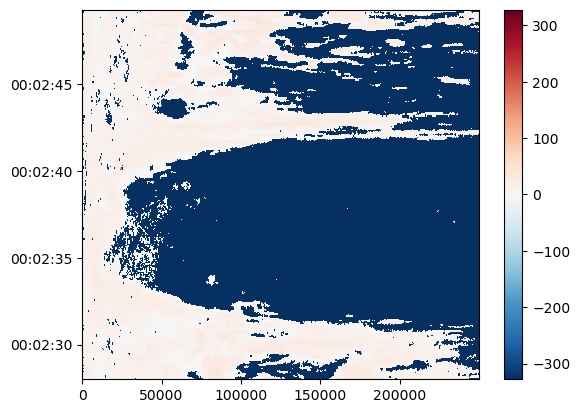

In [8]:
swp.DBZH.sortby("time").plot(x="range", y="time", add_labels=False)

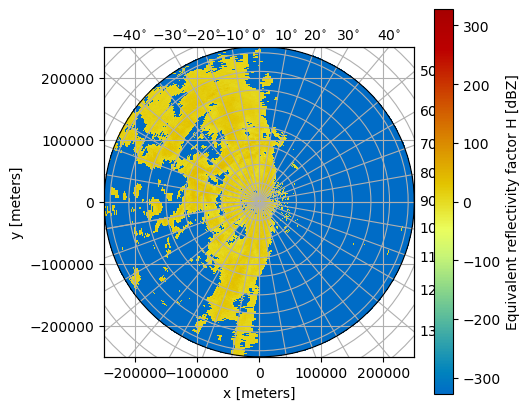

In [9]:
fig = plt.figure(figsize=(5, 5))
pm = swp.DBZH.wrl.vis.plot(crs={"latmin": 3e3}, fig=fig)

## Retrieve explicit group

In [10]:
swp_b = xr.open_dataset(
    f, engine="iris", group="sweep_0", backend_kwargs=dict(reindex_angle=False)
)
display(swp_b)

<xarray.Dataset> Size: 13MB
Dimensions:            (azimuth: 359, range: 833)
Coordinates:
    elevation          (azimuth) float32 1kB ...
    time               (azimuth) datetime64[ns] 3kB ...
  * range              (range) float32 3kB 150.0 450.0 ... 2.494e+05 2.498e+05
    longitude          float64 8B ...
    latitude           float64 8B ...
    altitude           float64 8B ...
  * azimuth            (azimuth) float32 1kB 0.03021 1.035 2.054 ... 358.0 359.0
Data variables: (12/16)
    DBTH               (azimuth, range) float32 1MB ...
    DBZH               (azimuth, range) float32 1MB ...
    VRADH              (azimuth, range) float32 1MB ...
    WRADH              (azimuth, range) float32 1MB ...
    ZDR                (azimuth, range) float32 1MB ...
    KDP                (azimuth, range) float32 1MB ...
    ...                 ...
    SNRH               (azimuth, range) float32 1MB ...
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B ...